# **FEDERAL UNIVERSITY OF RIO GRANDE DO NORTE**
## **ALGORITHMS AND DATA STRUCTURES II**

### **Instructor:**

1. Ivanovitch Medeiros Dantas da Silva

### **Students:**

1. André Eduardo Meneses do Nascimento
2. Matheus Gomes Diniz Andrade

# Installing Libraries

# Import Libraries

In [1]:
import numpy  as np
import pandas as pd

import networkx as nx

In [2]:
import matplotlib.pyplot as plt
import seaborn           as sns

# Notebook Patterns

In [3]:
plot = {
  "size": (18, 6),
  "title_size": 20,
  "title_color": "#262626",
  "subtitle_size": 16,
  "subtitle_color": "#868586",
}

# Data Aquisition

In [4]:
!gdown "https://raw.githubusercontent.com/alvarofpp/dataset-flights-brazil/main/data/air_traffic.graphml"

Downloading...
From: https://raw.githubusercontent.com/alvarofpp/dataset-flights-brazil/main/data/air_traffic.graphml
To: /content/air_traffic.graphml
999kB [00:00, 64.0MB/s]        


In [5]:
file_path = "air_traffic.graphml"

G = nx.read_graphml(file_path)

# Exploratory Analysis

Number of nodes in the network

In [6]:
G.number_of_nodes()

1083

Number of edges in the network

In [7]:
G.number_of_edges()

9613

## Assortativity

Assortativity is a metric that describes the tendency of similar nodes be connected.

- Assortativity $\rightarrow$ 1:

  **Assortative network**. In this case, nodes with similar degrees have a tendency to connect withtrad each other.

- Assortativity $\rightarrow$ 0:

  **Neutral network**. In this case, nodes don't have preference to connect.

- Assortativity $\rightarrow$ -1:

  **Disassortative network**. In this case, nodes with different degrees have a tendency to connect withtrad each other.
  

In [8]:
assortativity = nx.degree_assortativity_coefficient(G)

In [9]:
assortativity

-0.26968698005247493

In [10]:
network_degrees = pd.DataFrame()

In [11]:
for node_info in zip(list(G.nodes), dict(nx.degree(G)).values(), nx.average_neighbor_degree(G).values()):
  new_line = pd.DataFrame({
    "Self Degree": node_info[1],
    "Mean Neigh Degree": np.round(node_info[2], 2)
  }, index=[node_info[0]])

  network_degrees = pd.concat([
    network_degrees,
    new_line
  ])

In [12]:
network_degrees.head()

,Self Degree,Mean Neigh Degree
KDFW,35,100.00
KJFK,54,105.39
KMIA,194,53.40
SBCF,261,51.26
SBGL,401,37.71


In [13]:




# ax.set_ylabel("CO₂ (g)", fontsize=16)# Configuração dos dados
# network_degrees = pd.DataFrame({
#     "Self Degree": [1, 2, 3, 4, 5],
#     "Mean Neigh Degree": [2, 3, 4, 5, 6]
# })
# ax.set_xlabel("Tempo (s)", fontsize=16)

# ax.plot(cumsum_gasoline_17_08_2022, color=graph_colors["black"])
# ax.plot(cumsum_ethanol_27_02_2023, color=graph_colors["blue"])

# plt.text(1799, cumsum_gasoline_17_08_2022.iloc[-1], "Gasolina", weight="bold", fontsize=14)
# plt.text(1799, cumsum_ethanol_27_02_2023.iloc[-1], "Etanol", weight="bold", fontsize=14)

# plt.text(1799, cumsum_gasoline_17_08_2022.iloc[-1] - 100, cumsum_gasoline_17_08_2022.iloc[-1].round(2), weight="bold", fontsize=14)
# plt.text(1799, cumsum_ethanol_27_02_2023.iloc[-1] - 100, cumsum_ethanol_27_02_2023.iloc[-1].round(2), weight="bold", fontsize=14)

# plt.text(0, 2900, "CO₂ - Soma Acumulada", fontsize=18, color=text_colors["title"], weight="bold")
# plt.text(0, 2750, "Comparativo entre Gasolina e Etanol", fontsize=14, color=text_colors["subtitle"])

# plt.show()

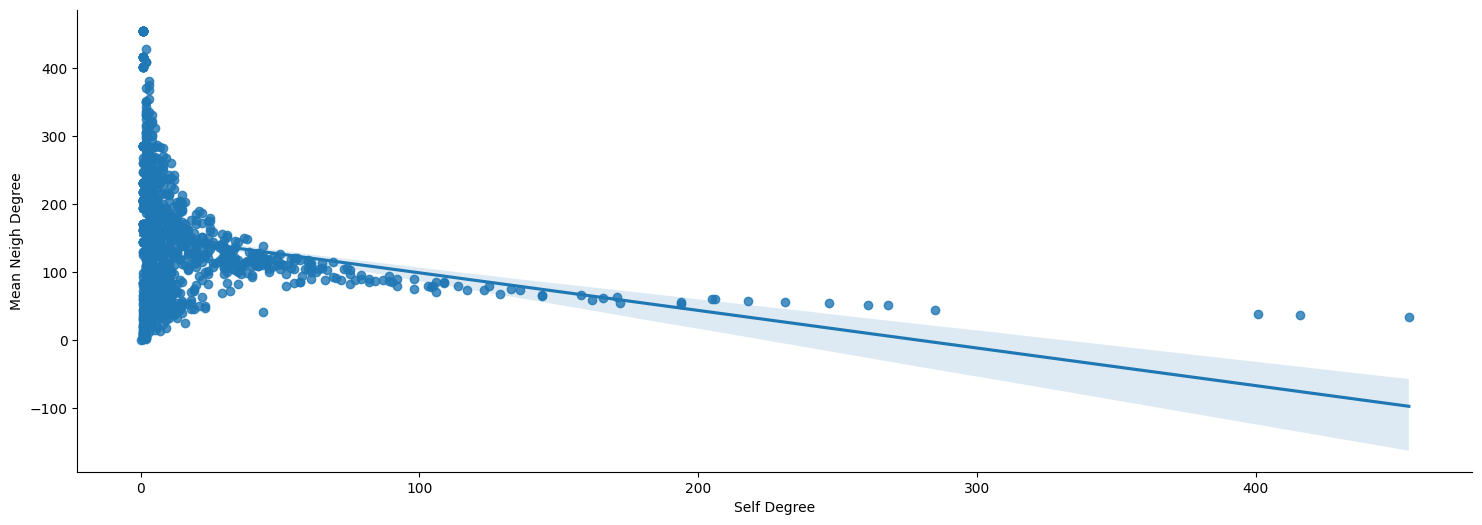

In [14]:
fig, ax = plt.subplots(figsize=plot["size"])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax = sns.regplot(data=network_degrees, x="Self Degree", y="Mean Neigh Degree")

plt.show()

In [15]:
higher_self_degree_idx = network_degrees["Self Degree"].argmax()
lower_self_degree_idx  = network_degrees["Self Degree"].argmin()

higher_mean_neigh_degree_idx = network_degrees["Mean Neigh Degree"].argmax()
lower_mean_neigh_degree_idx  = network_degrees["Mean Neigh Degree"].argmin()


higher_self_degree = network_degrees.iloc[higher_self_degree_idx]
lower_self_degree  = network_degrees.iloc[lower_self_degree_idx]

higher_mean_neigh_degree = network_degrees.iloc[higher_mean_neigh_degree_idx]
lower_mean_neigh_degree  = network_degrees.iloc[lower_mean_neigh_degree_idx]

In [34]:
network_degrees.iloc[9]

Self Degree          0.0
Mean Neigh Degree    0.0
Name: nan, dtype: float64

In [33]:
network_degrees["Self Degree"].argmin()

9

In [32]:
network_degrees["Mean Neigh Degree"].argmin()

9

In [31]:
network_degrees.iloc[lower_self_degree_idx, :]

Self Degree          0.0
Mean Neigh Degree    0.0
Name: nan, dtype: float64

In [28]:
print(f"higher_self_degree: {higher_self_degree.name}")
print(f"lower_self_degree: {lower_self_degree.name}")
print(f"higher_mean_neigh_degree: {higher_mean_neigh_degree.name}")
print(f"lower_mean_neigh_degree: {lower_mean_neigh_degree.name}")

higher_self_degree: SBGR
lower_self_degree: nan
higher_mean_neigh_degree: MDLR
lower_mean_neigh_degree: nan


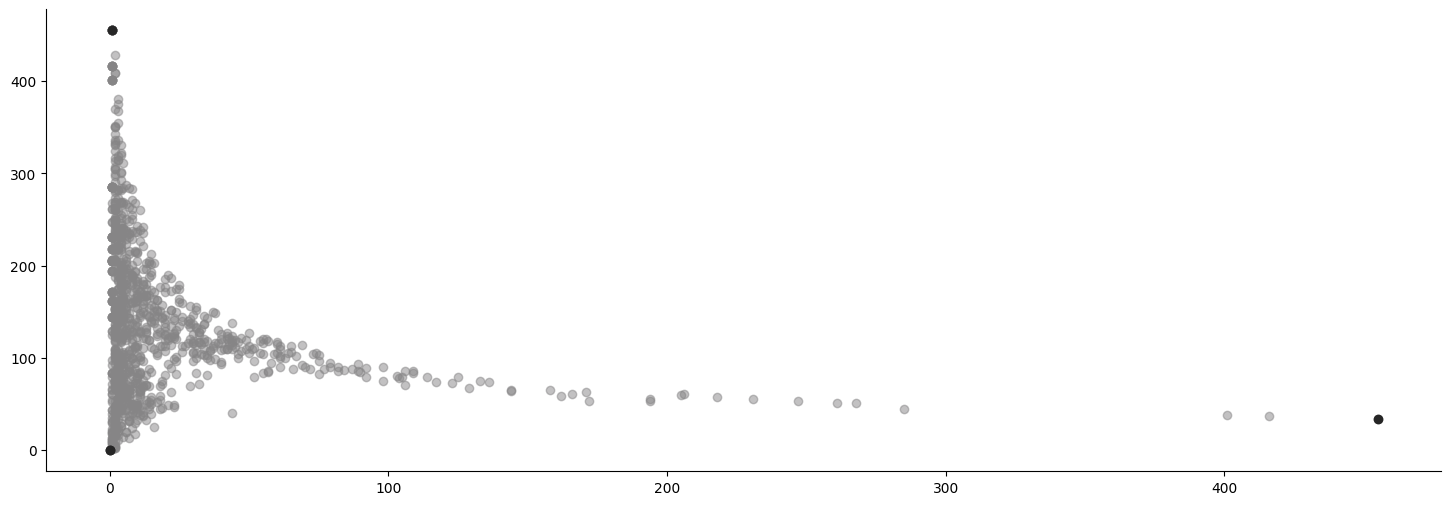

In [17]:
fig, ax = plt.subplots(figsize=plot["size"])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.scatter(data=network_degrees, x="Self Degree", y="Mean Neigh Degree", color="#868586", alpha=0.5)


ax.scatter(x=higher_self_degree["Self Degree"], y=higher_self_degree["Mean Neigh Degree"], color="#262626")
ax.scatter(x=lower_self_degree["Self Degree"], y=lower_self_degree["Mean Neigh Degree"], color="#262626")

ax.scatter(x=higher_mean_neigh_degree["Self Degree"], y=higher_mean_neigh_degree["Mean Neigh Degree"], color="#262626")
ax.scatter(x=lower_mean_neigh_degree["Self Degree"], y=lower_mean_neigh_degree["Mean Neigh Degree"], color="#262626")

plt.show()

In [18]:
G.nodes["KDFW"]

{'name': 'DALLAS & FORT WORTH, TEXAS',
 'country': 'ESTADOS UNIDOS DA AMÉRICA',
 'latitude': '32.896801',
 'longitude': '-97.038002'}